<a href="https://colab.research.google.com/github/Rishicode09/Projects/blob/main/Credit_Risk_Project_(built_with_AI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:36:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:36:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:36:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:36:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CV ROC-AUC: 0.8125097700897376 +/- 0.0040303041824750275
Holdout Accuracy: 0.759
Holdout ROC-AUC: 0.8385747172455209
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       515
           1       0.76      0.73      0.75       485

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



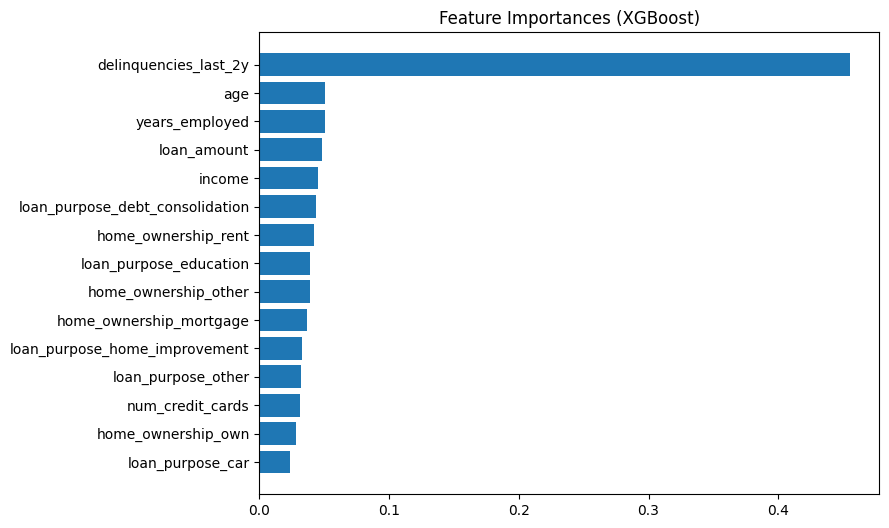

Sample applicant prediction → {'prob_default': np.float32(0.57437766), 'prediction': 1}


In [ ]:
# --- Colab Credit Risk Project: Employer-Ready Demo ---

# Install dependencies
!pip install scikit-learn xgboost pandas numpy matplotlib joblib

# -----------------------------
# Imports
# -----------------------------
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from xgboost import XGBClassifier

# -----------------------------
# Synthetic data generator
# -----------------------------
def generate_synthetic_data(n_samples=5000, random_seed=42):
    rng = np.random.default_rng(random_seed)

    age = rng.integers(21, 75, size=n_samples)
    income = rng.normal(55000, 20000, size=n_samples).clip(12000, 200000)
    loan_amount = rng.normal(15000, 8000, size=n_samples).clip(1000, 80000)
    years_employed = rng.integers(0, 40, size=n_samples)
    num_credit_cards = rng.integers(0, 12, size=n_samples)
    delinq_2y = rng.poisson(0.3, size=n_samples)

    loan_purpose = rng.choice(
        ["car","education","home_improvement","debt_consolidation","other"],
        size=n_samples
    )
    home_ownership = rng.choice(["rent","mortgage","own","other"], size=n_samples)

    debt_to_income = loan_amount / (income + 1e-6)
    base_risk = (
        1.5*debt_to_income +
        0.8*(delinq_2y > 0).astype(float) -
        0.02*years_employed -
        0.015*(age-21)
    )

    purpose_risk = np.select(
        [loan_purpose=="debt_consolidation", loan_purpose=="other", loan_purpose=="car",
         loan_purpose=="education", loan_purpose=="home_improvement"],
        [0.15,0.05,0.0,-0.05,-0.02], default=0.0
    )
    home_risk = np.select(
        [home_ownership=="rent", home_ownership=="mortgage", home_ownership=="own"],
        [0.08,0.02,-0.04], default=0.0
    )

    latent_risk = base_risk + purpose_risk + home_risk
    prob_default = 1 / (1+np.exp(-3*(latent_risk-latent_risk.mean())))
    defaulted = rng.binomial(1, prob_default)

    df = pd.DataFrame({
        "age":age,"income":income,"loan_amount":loan_amount,
        "years_employed":years_employed,"home_ownership":home_ownership,
        "loan_purpose":loan_purpose,"num_credit_cards":num_credit_cards,
        "delinquencies_last_2y":delinq_2y,"defaulted":defaulted
    })
    return df

# -----------------------------
# Pipeline builder (XGBoost)
# -----------------------------
def build_pipeline():
    numeric_features = ["age","income","loan_amount","years_employed","num_credit_cards","delinquencies_last_2y"]
    categorical_features = ["home_ownership","loan_purpose"]

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)

    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    return pipeline

# -----------------------------
# Training & evaluation
# -----------------------------
df = generate_synthetic_data()
X = df.drop(columns=["defaulted"])
y = df["defaulted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipeline = build_pipeline()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc")
print("CV ROC-AUC:", cv_scores.mean(), "+/-", cv_scores.std())

pipeline.fit(X_train, y_train)

y_prob = pipeline.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)
print("Holdout Accuracy:", accuracy_score(y_test,y_pred))
print("Holdout ROC-AUC:", roc_auc_score(y_test,y_prob))
print("Classification Report:")
print(classification_report(y_test,y_pred))

# -----------------------------
# Feature importance plot
# -----------------------------
preproc = pipeline.named_steps["preprocess"]
clf = pipeline.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    num_cols = preproc.transformers_[0][2]
    ohe = preproc.transformers_[1][1].named_steps["encoder"]
    cat_cols = preproc.transformers_[1][2]
    feature_names = list(num_cols) + list(ohe.get_feature_names_out(cat_cols))
    importances = clf.feature_importances_

    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8,6))
    plt.barh([feature_names[i] for i in idx], importances[idx])
    plt.title("Feature Importances (XGBoost)")
    plt.gca().invert_yaxis()
    plt.show()

# -----------------------------
# Simulated prediction request
# -----------------------------
sample = {
    "age": 35,
    "income": 72000,
    "loan_amount": 15000,
    "loan_purpose": "car",
    "years_employed": 6,
    "home_ownership": "mortgage",
    "num_credit_cards": 3,
    "delinquencies_last_2y": 0
}
sample_df = pd.DataFrame([sample])
prob = pipeline.predict_proba(sample_df)[0,1]
pred = int(prob>=0.5)
print("Sample applicant prediction →", {"prob_default":prob, "prediction":pred})